<a href="https://colab.research.google.com/github/Ogweno/portfolio/blob/main/%22Fraud_Detection_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm

# List of libraries to install
libraries = ['pyspark', '--packages com.databricks:spark-csv_2.10:1.2.0','ppscore', 'findspark', 'rpy2']

# Install libraries in silence
for lib in tqdm(libraries, desc="Installing libraries", unit="library"):
    os.system(f"pip install {lib} -q")

Installing libraries: 100%|██████████| 5/5 [01:21<00:00, 16.33s/library]


In [2]:
!pip install -q --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Fraud Detection Using pyspark ")\
        .config('spark.ui.port', '4050')\
        .config("spark.executor.memory", "8g") \
        .getOrCreate()

In [48]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import mean, stddev, format_number, col, countDistinct
from py4j.protocol import Py4JJavaError

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.util import MLUtils

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve,roc_auc_score, auc, precision_recall_curve, log_loss, mean_squared_error, mean_absolute_error, matthews_corrcoef, cohen_kappa_score

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Get the Kaggle secret Key

In [30]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
#!cp /content/drive/MyDrive/Kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle datasets

In [31]:
! kaggle datasets download mlg-ulb/creditcardfraud

 94% 62.0M/66.0M [00:00<00:00, 165MB/s]
100% 66.0M/66.0M [00:00<00:00, 161MB/s]


## Unzip the downloaded dataset

In [32]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


# View the dataset

In [51]:
#!wget -q https://www.kaggle.com/arockiaselciaa/creditcard.csv
df = spark.read.csv('/content/creditcard.csv',header=True,inferSchema=True)
df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

# Exploration of Data

# Find the binary and non-binary columns

In [34]:
def find_binary_columns(dataframe):
    binary_columns = []
    non_binary_columns = []

    for column in dataframe.columns:
        distinct_count = dataframe.select(countDistinct(column)).first()[0]
        if distinct_count == 2:
            binary_columns.append(column)
        else:
            non_binary_columns.append(column)

    return binary_columns, non_binary_columns



In [35]:
# Usage:
# Assuming 'df' is your DataFrame
binary_cols, non_binary_cols = find_binary_columns(df)
print("Binary Columns:", binary_cols)
print("Non-Binary Columns:", non_binary_cols)

Binary Columns: ['Class']
Non-Binary Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


# Statistical  and descriptive Summary of data

In [58]:
def check_df(dataframe, head=5):
    # Schema
    print("########## Schema #############")
    print(dataframe.printSchema())

    # Summary Statistics
    print("\n########## Summary Statistics #############")
    dataframe_summary = dataframe.summary().toPandas()
    dataframe_summary = dataframe_summary.rename(index={'summary': 'Statistics'})
    print(tabulate(dataframe_summary, headers='keys', tablefmt='psql'))

    # Head of Data
    print("\n########## Head of Data #############")
    print(tabulate(dataframe.limit(head).toPandas(), headers='keys', tablefmt='psql'))

    # Tail of Data
    print("\n########## Tail of Data #############")
    print(tabulate(dataframe.tail(head), headers='keys', tablefmt='psql', showindex=False))

    # Null Values
    print("\n########## Null Values of Data #############")
    null_counts = dataframe.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dataframe.columns]).collect()[0].asDict()
    null_data = [{'Column': column, 'Null Count': count} for column, count in null_counts.items()]
    print(tabulate(null_data, headers='keys', tablefmt='psql'))

    # Visualize Missing Values
    print("\n########## Visualization of Missing Values #############")
    msno.matrix(dataframe.toPandas(), color=(0.2, 0.4, 0.6))  # Specify a custom color
    plt.show()

    # Describe of the Numerical Data
    print("\n########## Describe of the Numerical Data #############")
    numerical_summary = dataframe.describe().toPandas()
    numerical_summary = numerical_summary.rename(index={'summary': 'Statistics'})
    print(tabulate(numerical_summary, headers='keys', tablefmt='psql'))

    # Find Unique Values
    print("\n########## Unique Values #############")
    unique_counts = dataframe.select([countDistinct(c).alias(c) for c in dataframe.columns]).collect()[0].asDict()
    unique_data = [{'Column': column, 'Unique Count': count} for column, count in unique_counts.items()]
    print(tabulate(unique_data, headers='keys', tablefmt='psql'))

    # Separate Attributes into Numeric and Categorical
    numeric_cols = [col_name for col_name, data_type in dataframe.dtypes if data_type != "string"]
    categorical_cols = [col_name for col_name, data_type in dataframe.dtypes if data_type == "string"]

    # Plot Distribution of Numeric Attributes
    print("\n########## Distribution of Numeric Attributes #############")
    num_cols_count = len(numeric_cols)
    num_rows = (num_cols_count + 5) // 6  # Calculate number of rows for subplots
    fig, axes = plt.subplots(num_rows, 6, figsize=(8*num_rows, 6*num_rows))

    for i, col in enumerate(numeric_cols):
        ax = axes[i // 6, i % 6]  # Get current axis
        sns.histplot(dataframe.select(col).toPandas(), bins=20, color='blue', ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Plot Distribution of Categorical Attributes
    print("\n########## Distribution of Categorical Attributes #############")
    for col in categorical_cols:
        plt.figure(figsize=(8, 6))
        cat_distribution = dataframe.groupBy(col).count().toPandas()
        labels = cat_distribution[col].apply(lambda x: f"{x}: {cat_distribution[cat_distribution[col] == x]['count'].values[0]}")
        plt.pie(cat_distribution['count'], labels=labels, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')
        plt.title(f'Distribution of {col}')
        plt.show()

    # Check the number of occurrences of each class label and plot the information
    non_fraud = dataframe.filter(dataframe.Class == 0)
    fraud = dataframe.filter(dataframe.Class == 1)

    class_labels = ['Non-Fraudulent', 'Fraudulent']
    class_counts = [non_fraud.count(), fraud.count()]

    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_counts, color=['blue', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()




########## Schema #############
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable

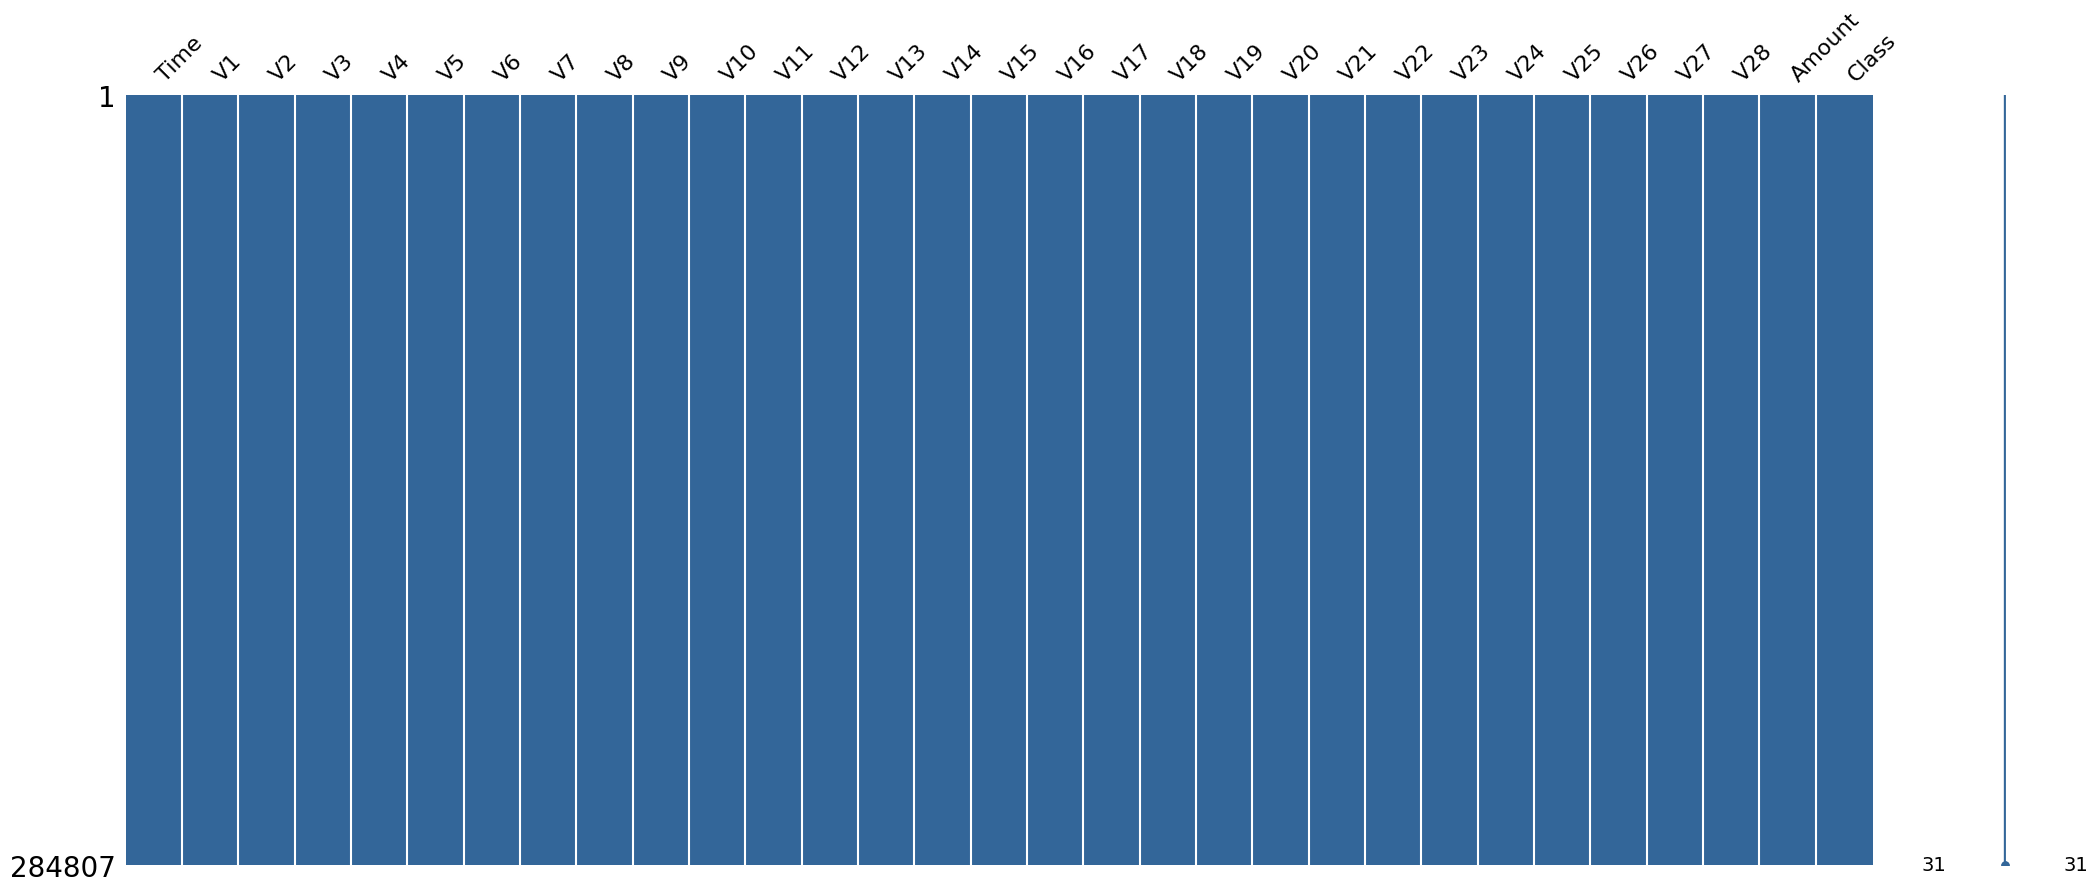


########## Describe of the Numerical Data #############
+----+-----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------------+
|    | summary   |     Time |               V1 |               V2 |               V3 |               V4 |               V5 |               V6 |               V7 |               V8 |               V9 |              V10 |              V11 |              V12 |              V13 |              V14 |              V15 |              V16 |              V17

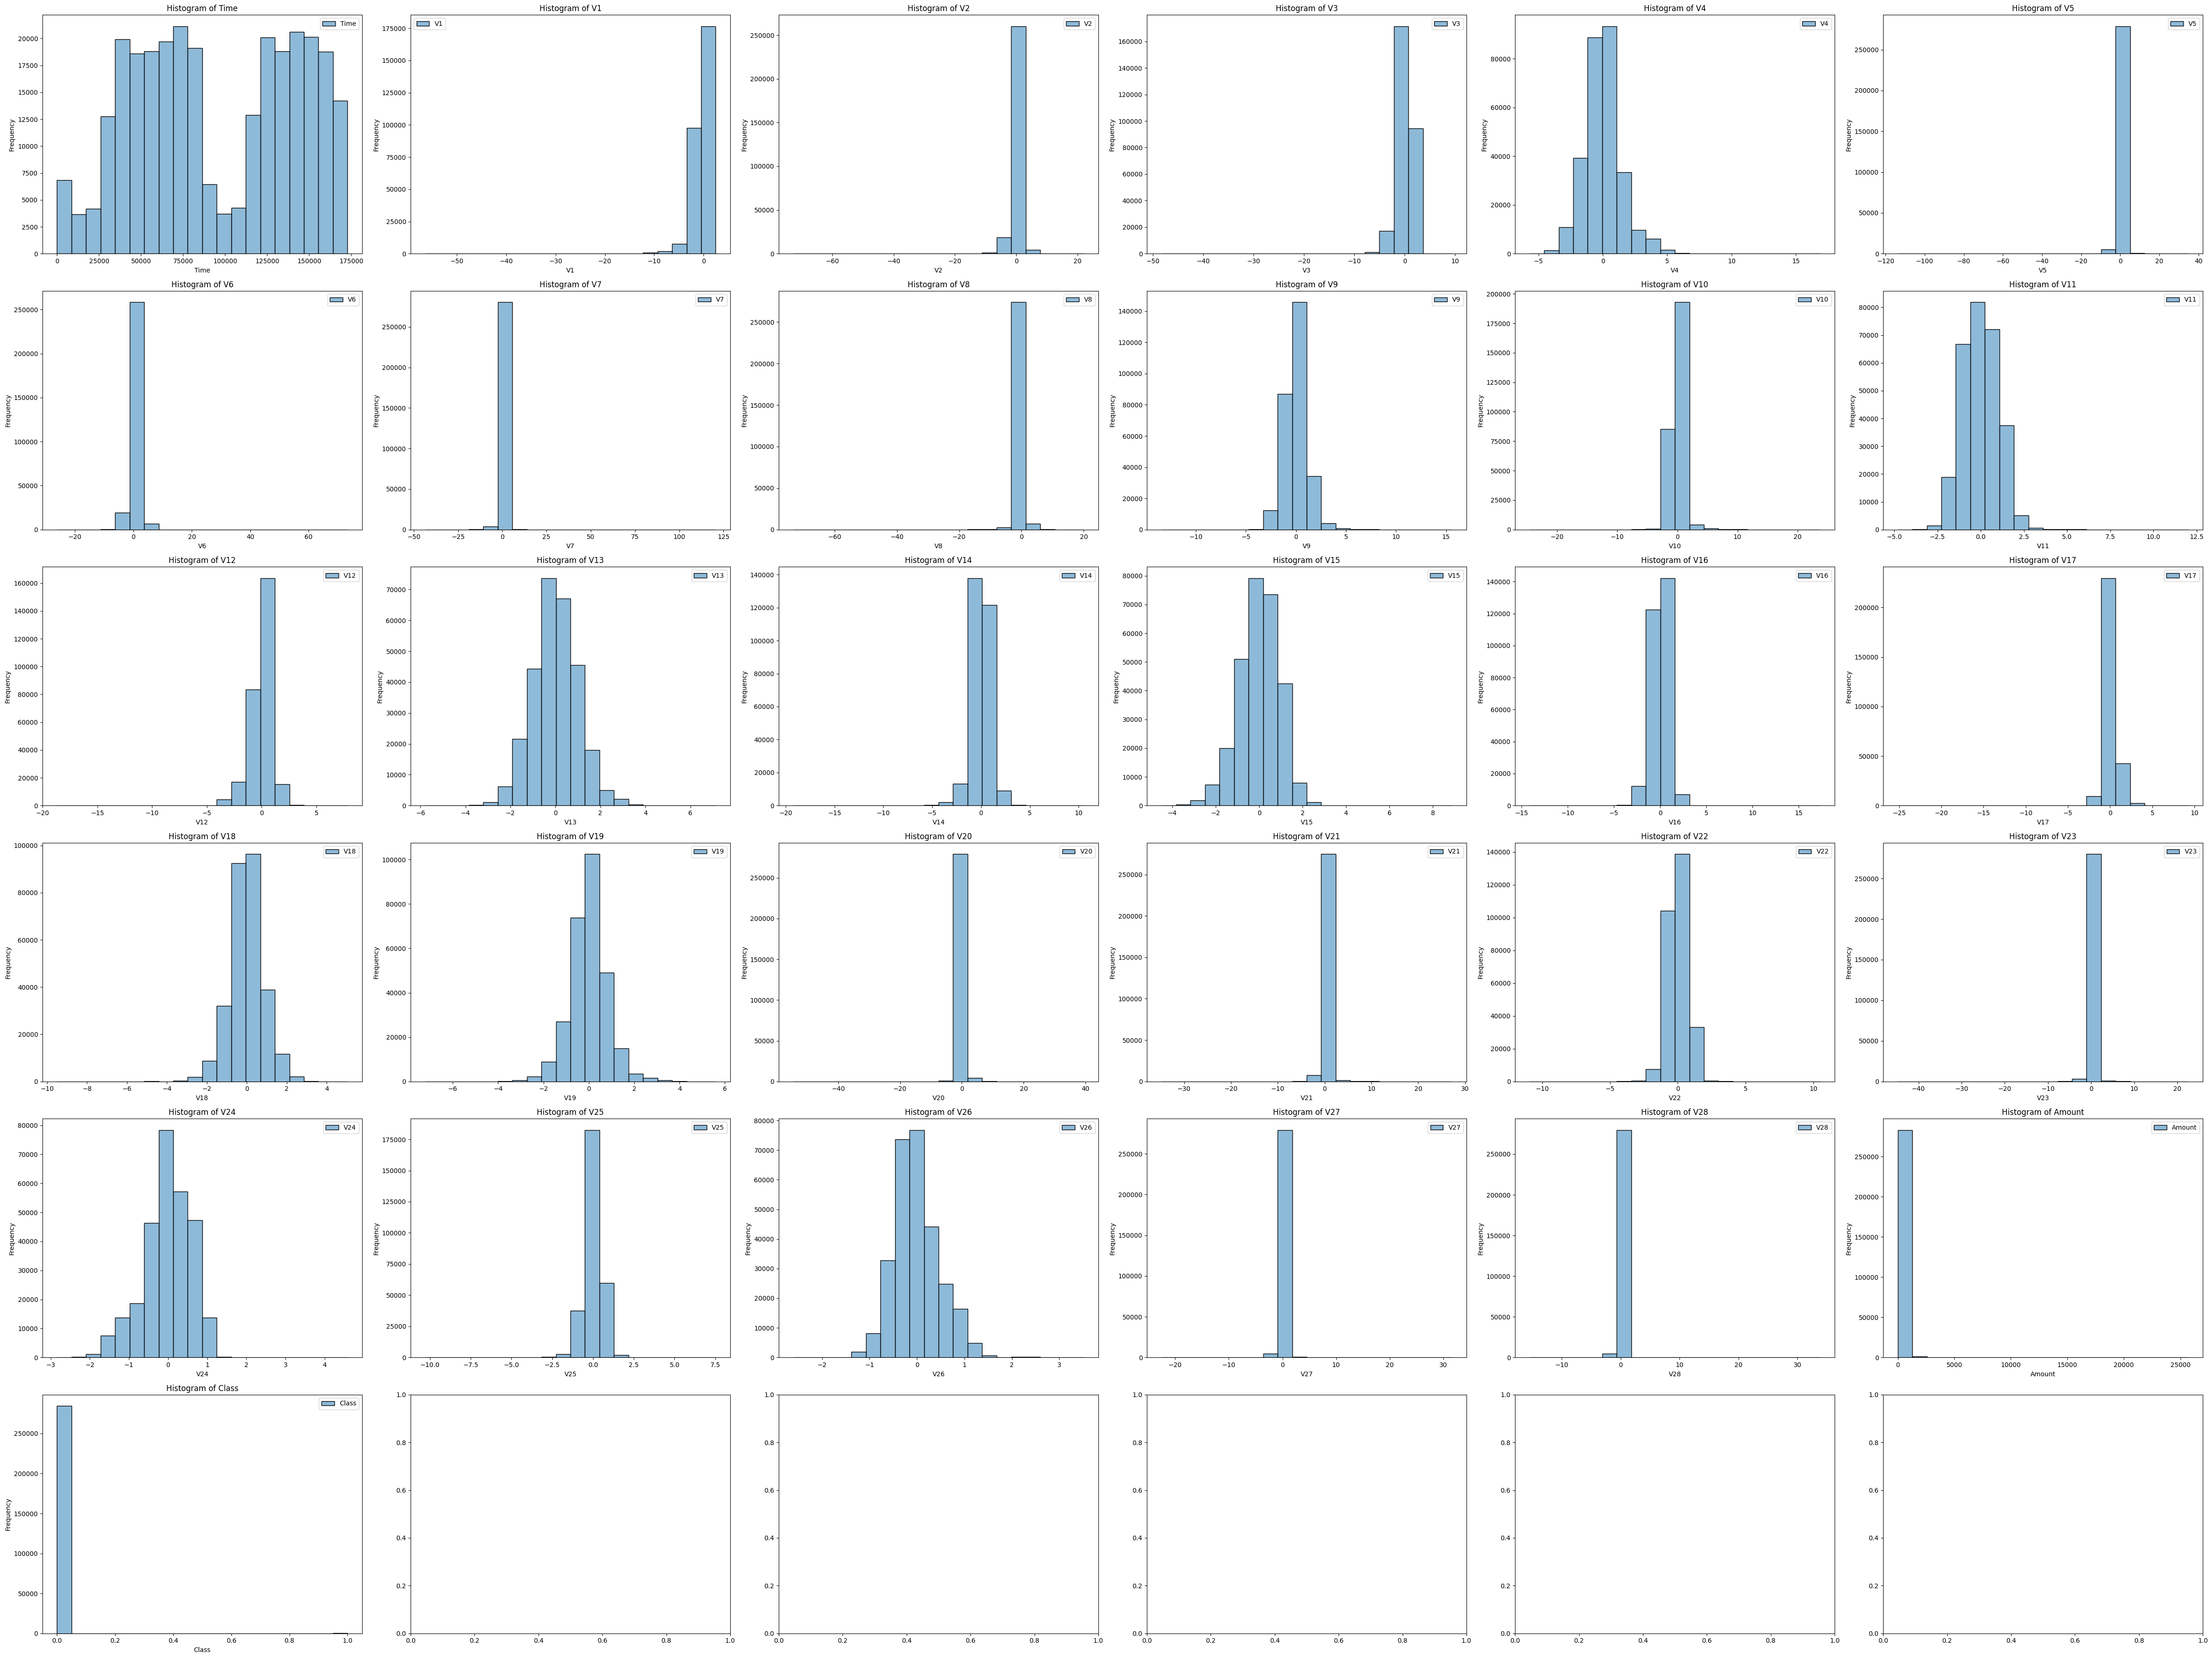


########## Distribution of Categorical Attributes #############


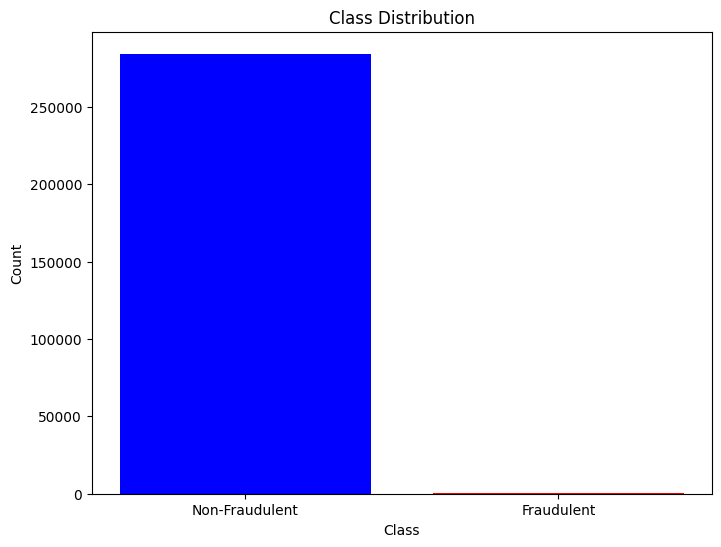

In [59]:
# Assuming 'df' is your DataFrame
check_df(df)

# Unique values
We have two unique values in the ***Class*** which we will consider as the target variable. The ***Amount*** has *32767* unique values, and ***Time*** has *124592* unique values. The rest of the Features have a unique values of *275663*

# Fixing data imbalance
Create two functions: *balance_classes* to balance the classes and *plot_class_distribution* to plot the distribution of classes.

* The balance_classes function takes a DataFrame, and optionally allows specifying the class column, sample size, and random state.
* The plot_class_distribution function takes the balanced DataFrame and plots the distribution of classes.

In [38]:
def balance_classes(dataframe, class_column='Class', sample_size=None, random_state=None):
    # Convert PySpark DataFrame to Pandas DataFrame
    data = dataframe.toPandas()

    # Shuffle the DataFrame
    data = data.sample(frac=1, random_state=random_state)

    # Determine the sample size
    if sample_size is None:
        sample_size = min(data[class_column].value_counts())

    # Extract fraud and non-fraud classes
    fraud_df = data.loc[data[class_column] == 1]
    non_fraud_df = data.loc[data[class_column] == 0][:sample_size]

    # Concatenate fraud and non-fraud classes
    balanced_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle the balanced DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=random_state)

    return balanced_df

def plot_class_distribution(dataframe, class_column='Class'):
    # Print class distribution
    print('Distribution of the Classes in the subsample dataset:')
    print(dataframe[class_column].value_counts() / len(dataframe))

    # Plot class distribution
    plt.figure(figsize=(5, 4))
    sns.countplot(x=class_column, data=dataframe)  # Specify 'x' parameter explicitly
    plt.title('Equally Distributed Classes', fontsize=14)
    plt.savefig('Figures_fraud/Fraud_dist_sampled.jpg')
    plt.show()

In [39]:
'''Check if directory exists, if not, create it'''
import os
# You should change 'images' to your preferred folder.
MYDIR = ("Figures_fraud")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")

created folder :  Figures_fraud


Distribution of the Classes in the subsample dataset:
1    0.5
0    0.5
Name: Class, dtype: float64


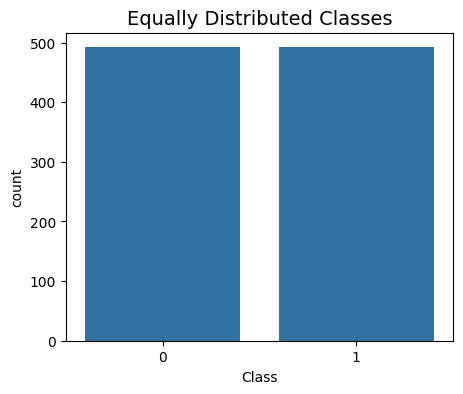

In [40]:
# Assuming 'df' is your DataFrame
balanced_df = balance_classes(df)
plot_class_distribution(balanced_df)

In [41]:
#Lets apply scaling techniques on the Amount feature to transform the range of values. We drop the original Amount column and add a new column with the scaled values. We also drop the Time column as it is irrelevant.
#First Step in PySpark is Make Vector of the Values in Amount Column
def scale_and_remove_columns(dataframe, input_col="Amount", output_col="SAmount", drop_cols=["Amount", "Amount_Vect", "Time"]):
    # Step 1: Make Vector of the Values in Amount Column
    assembler = VectorAssembler(inputCols=[input_col], outputCol="Amount_Vect")
    output = assembler.transform(dataframe)
    output.show(5)

    # Step 2: Apply Scaling on it
    scaler = StandardScaler(inputCol="Amount_Vect", outputCol=output_col, withStd=True, withMean=False)
    final_df = scaler.fit(output).transform(output)
    final_df.show(5)

    # Step 3: Remove unwanted columns
    final_df = final_df.drop(*drop_cols)
    final_df.show(5)

    return final_df

# Convert Pandas DataFrame to PySpark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Call the function with the PySpark DataFrame
scaled_removed_df = scale_and_remove_columns(balanced_spark_df)


+--------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+------------------+-------------------+------+-----+-----------+
|    Time|                V1|                V2|                V3|                V4|                V5|                  V6|                V7|                  V8|                V9|               V10|              V11|               V12|               V13|              V14|               V15|               V16|              V17|                V18|               V19|               V20|               V21|              

In [42]:
def prepare_features(dataframe, numericCols, binaryCol):
    # Exclude the binary column from the numeric columns
    numericCols = [col for col in numericCols if col != binaryCol]

    # VectorAssembler to combine numeric features into a single vector
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    output = assembler.transform(dataframe)

    # Select only the features and the binary column
    selectedCols = ["features", binaryCol]
    return output.select(selectedCols)


selectedNumericCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
binaryCol = 'Class'

# Convert Pandas DataFrame to PySpark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

mdf = prepare_features(balanced_spark_df, selectedNumericCols, binaryCol)
mdf.show(5)


+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[-28.524267593840...|    1|
|[-1.9286132666590...|    1|
|[-0.5201925851789...|    0|
|[-3.0034594221340...|    1|
|[1.18801585176914...|    0|
+--------------------+-----+
only showing top 5 rows



In [43]:
def prepare_features(dataframe, numericCols, targetCol):
    from pyspark.ml.feature import VectorAssembler, StandardScaler

    # Assemble the numeric columns into a features vector
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    mdf = assembler.transform(dataframe)

    # Check if the output column exists
    if "features" in mdf.columns:
        # Scale numeric features between -1 and 1
        if "scaled_features" in mdf.columns:
            # Drop the existing scaled_features column
            mdf = mdf.drop("scaled_features")

        scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
        scaler_model = scaler.fit(mdf)
        mdf = scaler_model.transform(mdf)
    else:
        raise ValueError("Column 'features' not found in dataframe.")

    # Rename the target column
    mdf = mdf.withColumnRenamed(targetCol, "label")

    # Print the counts of training and test datasets
    train, test = mdf.randomSplit([0.7, 0.3], seed=2018)
    print("Training Dataset Count: " + str(train.count()))
    print("Test Dataset Count: " + str(test.count()))

    return mdf






In [44]:
# Assuming selectedNumericCols is defined
selectedNumericCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
targetCol = "Class"

balanced_spark_df = spark.createDataFrame(balanced_df)

# Call the prepare_features function
mdf = prepare_features(balanced_spark_df, selectedNumericCols, targetCol)

# Split the data into train and test sets
train, test = mdf.randomSplit([0.7, 0.3], seed=2018)


Training Dataset Count: 704
Test Dataset Count: 280


# Model Evaluation Metrics for Machine Learning

In classification problems, we use two types of algorithms (dependent on the kind of output it creates):

* Class output: Algorithms like SVM and KNN create a class output. For instance, in a binary classification problem, the outputs will be either 0 or 1. However, today we have algorithms that can convert these class outputs to probability. But these algorithms are not well accepted by the statistics community.
* Probability output: Algorithms like Logistic Regression, Random Forest, Gradient Boosting, Adaboost, etc., give probability outputs. Converting probability outputs to class output is just a matter of creating a threshold probability.

A few definition of the confusion matrix can be seen in the figure below

![](https://www.analyticsvidhya.com/blog/wp-content/uploads/2015/01/Confusion_matrix.png)

# Mathematical expressions


The most commonly used evaluation metrics for binary classification are accuracy, sensitivity, specificity, and precision, which express the percentage of correctly classified instances in the set of all the instances, the truly positive instances, the truly negative instances, or the instances classified as positive, respectively.


\begin{aligned} \mathrm{Acc.}&=\frac{\textrm{TP}+\textrm{TN}}{\textrm{TP}+\textrm{TN}+\textrm{FP}+\textrm{FN}}\in [0,1],\quad \mathrm{Sen.}=\mathrm{Rec.}=\frac{\textrm{TP}}{\textrm{TP}+\textrm{FN}}\in [0,1],\\ \mathrm{Spe.}&=\frac{\textrm{TN}}{\textrm{TN}+\textrm{FP}}\in [0,1],\quad \mathrm{Pre.}=\frac{\textrm{TP}}{\textrm{TP}+\textrm{FP}}\in [0,1], \end{aligned}

## F1-Score
\begin{aligned} \textrm{F1}=\frac{2\cdot \mathrm{Pre.}\cdot \mathrm{Rec.}}{\mathrm{Pre.}+\mathrm{Rec.}}\in [0,1], \end{aligned}

## Cohen’s kappa
The Kappa statistic is a measure of inter-rater reliability


\begin{aligned} \kappa =\frac{\mathrm{Acc.}-p_e}{1-p_e}\in (-\infty ,1]\quad \text {with}\quad p_e=\frac{(\textrm{TP}+\textrm{FN})(\textrm{TP}+\textrm{FP})+(\textrm{TN}+\textrm{FP})(\textrm{TN}+\textrm{FN})}{(\textrm{TP}+\textrm{TN}+\textrm{FP}+\textrm{FN})^2} \end{aligned}

Cohen suggested the Kappa statistic be interpreted as:

![](https://www.theanalysisfactor.com/wp-content/uploads/2020/04/27875.3a406f94474b739bf1d0a535018a4fd2.png)


## Matthews’ correlation coefficient (MCC), defined as

\begin{aligned} \textrm{MCC}=\frac{\textrm{TN}\cdot \textrm{TP}-\textrm{FN}\cdot \textrm{FP}}{\sqrt{(\textrm{TP}+\textrm{FP})(\textrm{TP}+\textrm{FN})(\textrm{TN}+\textrm{FP})(\textrm{TN}+\textrm{FN})}}\in [-1,1], \end{aligned}

## cross-entropy loss defined as

\begin{aligned} H(p,q)=-\sum ^n_{i=1}p_i\log (q_i). \end{aligned}

Another way to evaluate the model is to use some error measurement, such as mean absolute error (MAE) \begin{aligned} \sum ^n_{i=1}|x_i-y_i|\end{aligned} or mean squared error (MSE) \begin{aligned}\sum ^n_{i=1}(x_i-y_i)^2\end{aligned}

# Compare all models using various performance metrics

In [161]:
def plot_roc_curve(models_dict):
    plt.figure(figsize=(8, 6))
    for model_name, metrics in models_dict.items():
        fpr, tpr = metrics["fpr"], metrics["tpr"]
        roc_auc = metrics["roc_auc"]
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_roc_auc_curve(models_dict):
    plt.figure(figsize=(8, 6))
    for model_name, metrics in models_dict.items():
        fpr, tpr = metrics["fpr"], metrics["tpr"]
        roc_auc = metrics["roc_auc"]
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend()
    plt.show()

def plot_model_comparison(models_metrics):
    models = list(models_metrics.keys())
    metrics = list(models_metrics[models[0]].keys())  # Get the list of metrics from the first model

    for metric in metrics:
        plt.figure(figsize=(10, 6))  # Create a new figure for each metric

        metric_values = [models_metrics[model][metric] for model in models]

        # Filter out non-numeric values and empty lists
        metric_values = [value for value in metric_values if isinstance(value, (int, float)) or (isinstance(value, list) and len(value) > 0)]

        if metric_values:
            # Convert values to a NumPy array
            metric_values = np.array(metric_values, dtype=float)

            # Sort the indices based on metric values (from lowest to highest)
            sorted_indices = np.argsort(metric_values)

            # Reorder model names and metric values based on sorted indices
            models_sorted = [models[i] for i in sorted_indices]
            metric_values_sorted = metric_values[sorted_indices]

            plt.barh(models_sorted, metric_values_sorted, color='skyblue')

            plt.xlabel('Metrics Value')
            plt.ylabel('Models')
            plt.title(f'Model Comparison - {metric}')
            plt.show()

In [123]:
def evaluate_model(model, train, test, model_name):
    # Fit the model on the training data
    model_fit = model.fit(train)

    # Make predictions on the test data
    predictions = model_fit.transform(test)

    # Evaluate the model's performance
    evaluator_multiclass = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = evaluator_multiclass.evaluate(predictions, {evaluator_multiclass.metricName: "accuracy"})

    evaluator_binary = BinaryClassificationEvaluator(labelCol="label")
    auc_score = evaluator_binary.evaluate(predictions)

    # Calculate confusion matrix
    preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC curve if 'probability' column exists
    if 'probability' in predictions.columns:
        y_test = [row.label for row in predictions.select("label").collect()]
        y_score = [row.probability[1] for row in predictions.select("probability").collect()]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Calculate additional metrics
        precision, recall, f1_score_non_fraud, f1_score_fraud = None, None, None, None
        logloss, mse, mae, mcc, kappa = None, None, None, None, None

        y_score = [row.probability[1] for row in predictions.select("probability").collect()]
        y_test = [row.label for row in predictions.select("label").collect()]
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        logloss = log_loss(y_test, y_score)
        mse = mean_squared_error(y_test, y_score)
        mae = mean_absolute_error(y_test, y_score)
        mcc = matthews_corrcoef(y_test, [1 if val > 0.5 else 0 for val in y_score])
        kappa = cohen_kappa_score(y_test, [1 if val > 0.5 else 0 for val in y_score])
        f1_score_non_fraud = metrics.fMeasure(0.0)
        f1_score_fraud = metrics.fMeasure(1.0)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Store metrics in models_metrics dictionary
        models_metrics[model_name] = {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc}

        # Print metrics in a table format
        print(f"Metrics for {model_name}:")
        metrics_table = [
            ["Accuracy", round(accuracy, 2)],
            ["AUC", round(auc_score, 2)],
            ["Precision (Non-Fraud)", round(precision[0], 2) if precision is not None else None],
            ["Precision (Fraud)", round(precision[1], 2) if precision is not None else None],
            ["Recall (Non-Fraud)", round(recall[0], 2) if recall is not None else None],
            ["Recall (Fraud)", round(recall[1], 2) if recall is not None else None],
            ["F1-score (Non-Fraud)", round(f1_score_non_fraud, 2) if f1_score_non_fraud is not None else None],
            ["F1-score (Fraud)", round(f1_score_fraud, 2) if f1_score_fraud is not None else None],
            ["Log Loss", round(logloss, 2) if logloss is not None else None],
            ["Mean Squared Error", round(mse, 2) if mse is not None else None],
            ["Mean Absolute Error", round(mae, 2) if mae is not None else None],
            ["Matthews Correlation Coefficient", round(mcc, 2) if mcc is not None else None],
            ["Cohen's Kappa", round(kappa, 2) if kappa is not None else None]
        ]
        print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))
        return metrics_table
    else:
        # Return an empty dictionary if no metrics are calculated
        return {}



In [122]:
# Define models to evaluate
models_to_evaluate = [
    (RandomForestClassifier(featuresCol='features', labelCol='label'), "Random Forest"),
    (DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3), 'Decision Tree Classifier'),
    (LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8),'Logistic Regression Model'),
    (GBTClassifier(labelCol='label', featuresCol='features'),'Gradient-boosted Tree classifier'),
    (LinearSVC(labelCol='label', featuresCol='features'),'Linear SVM')
]


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


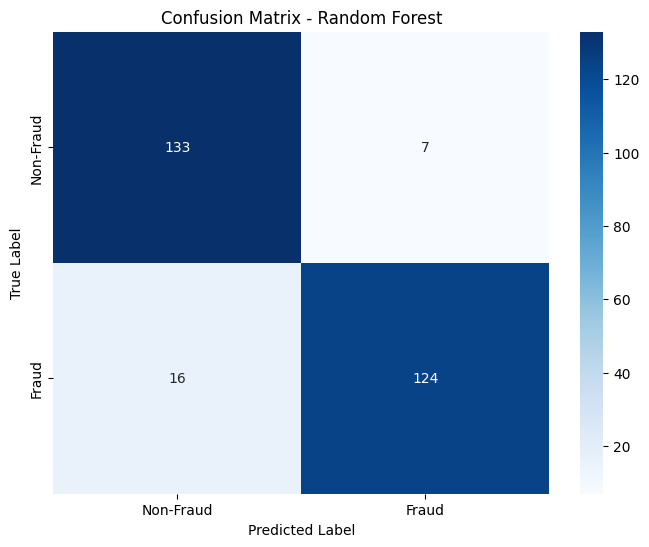

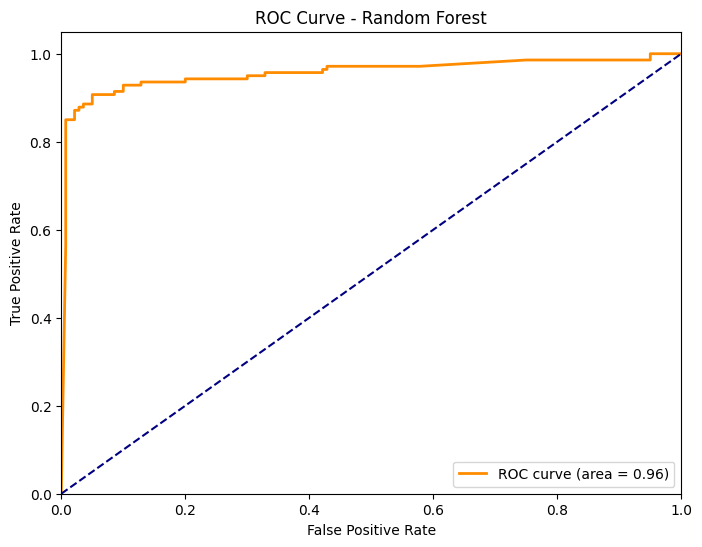

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


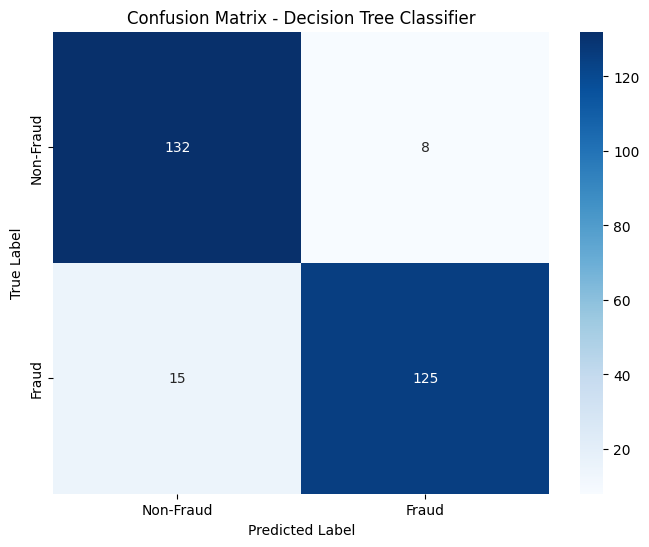

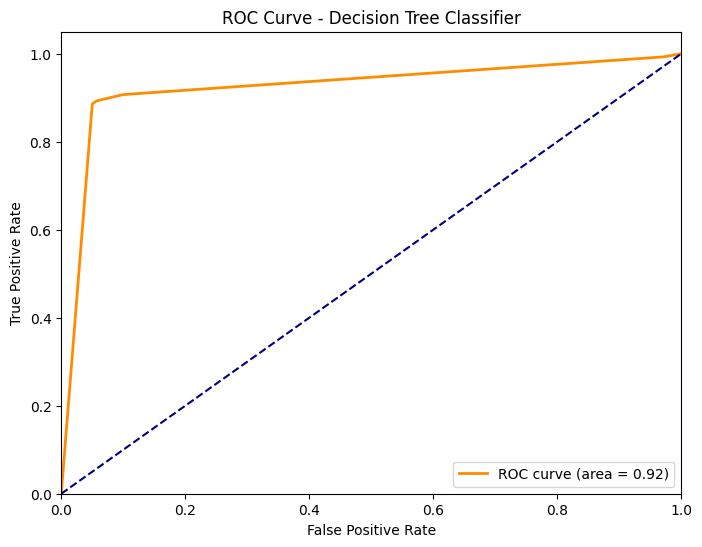

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


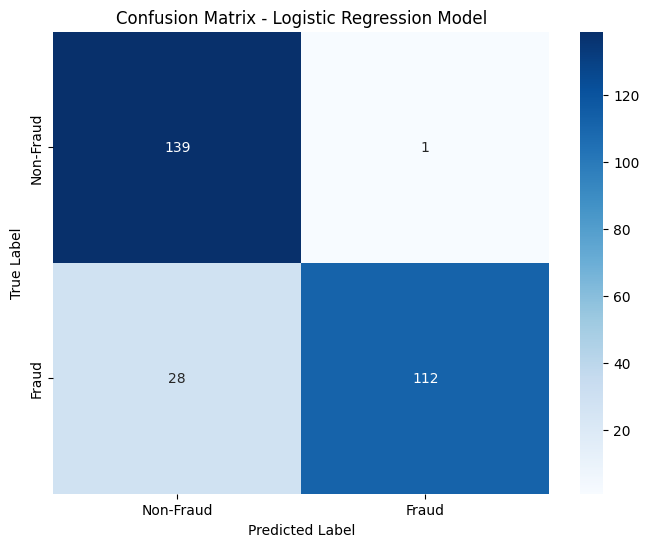

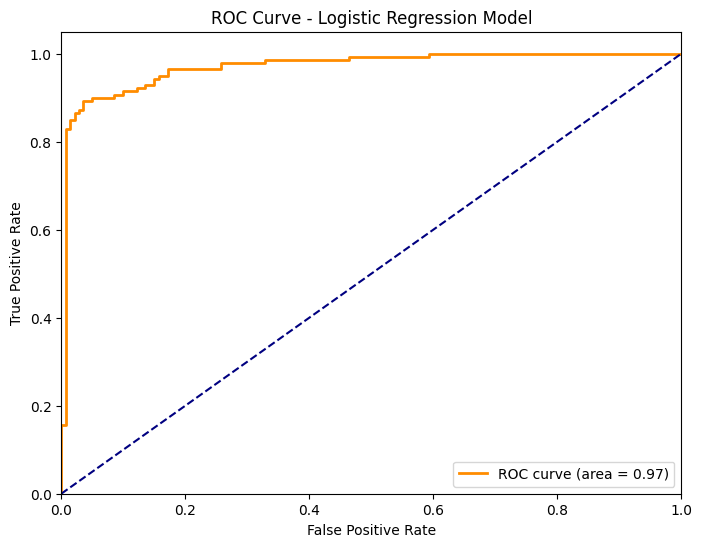

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


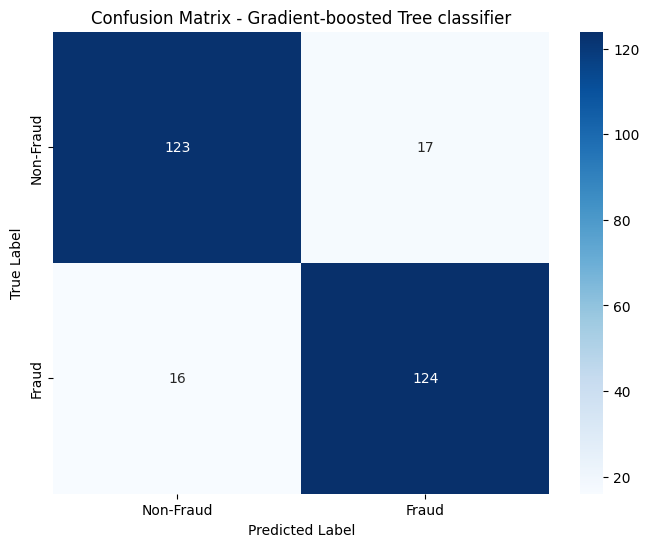

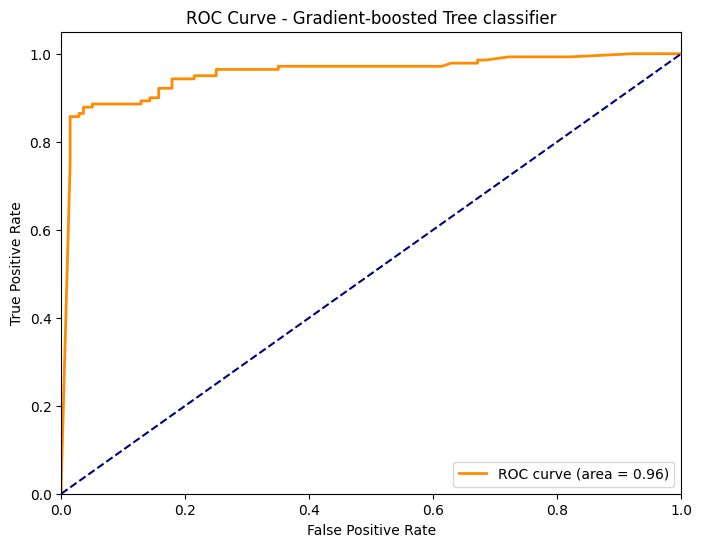

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


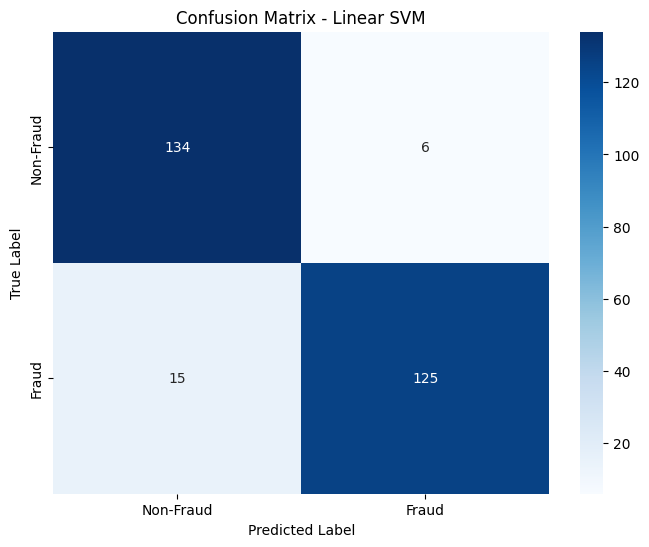

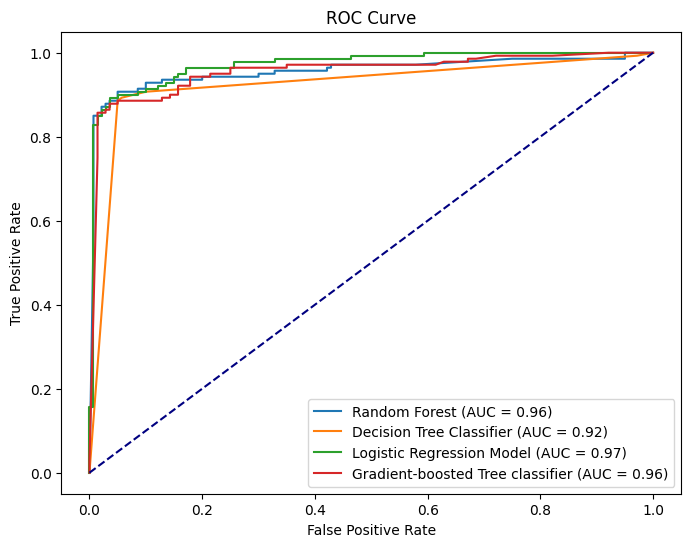

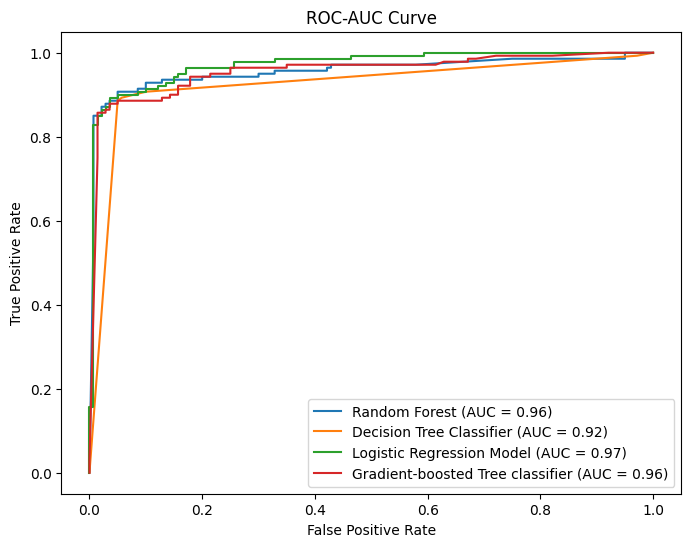

In [189]:
# Store metrics in models_metrics dictionary
models_metrics = {}
metrics_table_all_models = []

for model, model_name in models_to_evaluate:
    model_metrics = evaluate_model(model, train, test, model_name)

    if model_metrics:
        # Collect metrics for models_metrics dictionary
        models_metrics[model_name] = model_metrics

        # Collect metrics for metrics_table_all_models list
        for metric_name, metric_value in model_metrics.items():
            metrics_table_all_models.append([model_name, metric_name, metric_value])

# Print metrics for all models in a single table
#print("Metrics for all models:")
#print(tabulate(metrics_table_all_models, headers=["Model", "Metric", "Value"], tablefmt="grid"))

# Convert metrics_table_all_models into a pandas DataFrame
df = pd.DataFrame(metrics_table_all_models)

# Plot ROC curve
plot_roc_curve(models_metrics)

# Plot ROC-AUC curve
plot_roc_auc_curve(models_metrics)



# Model comparison using various performance metrics

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

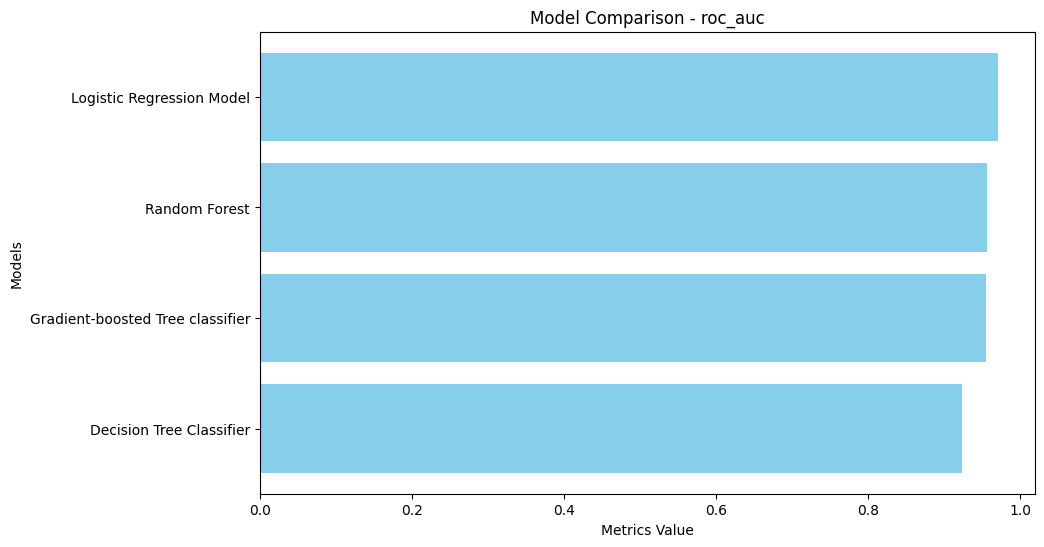

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

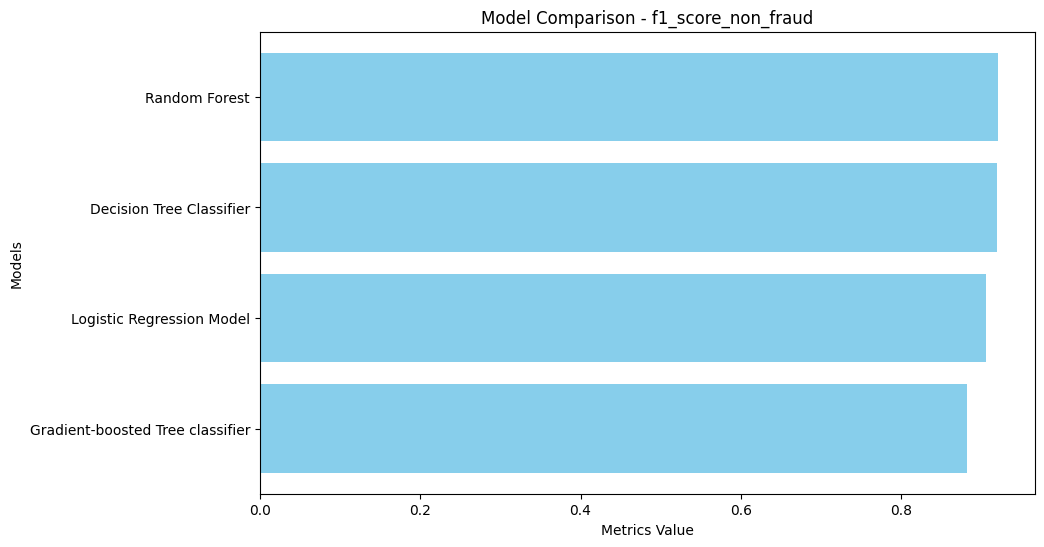

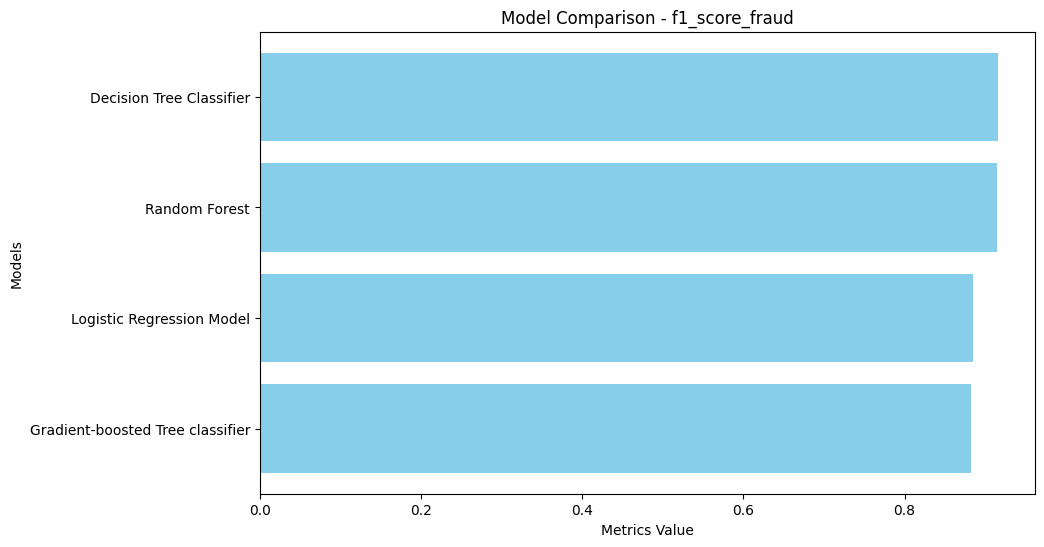

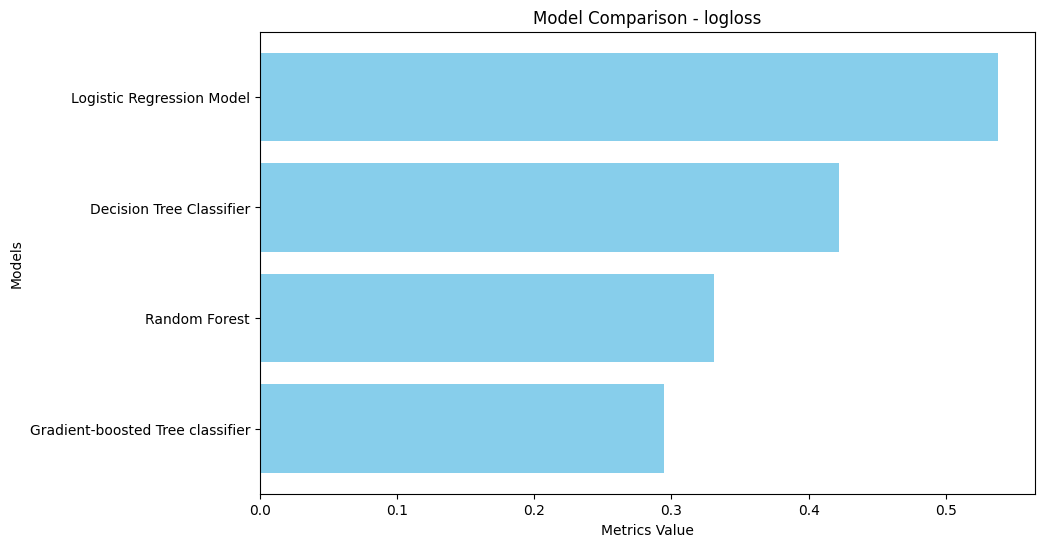

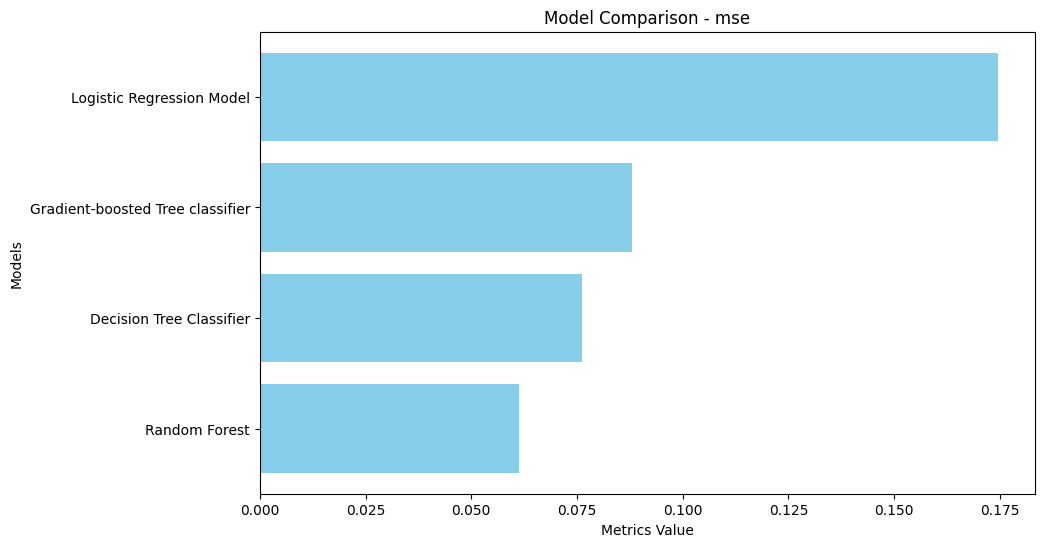

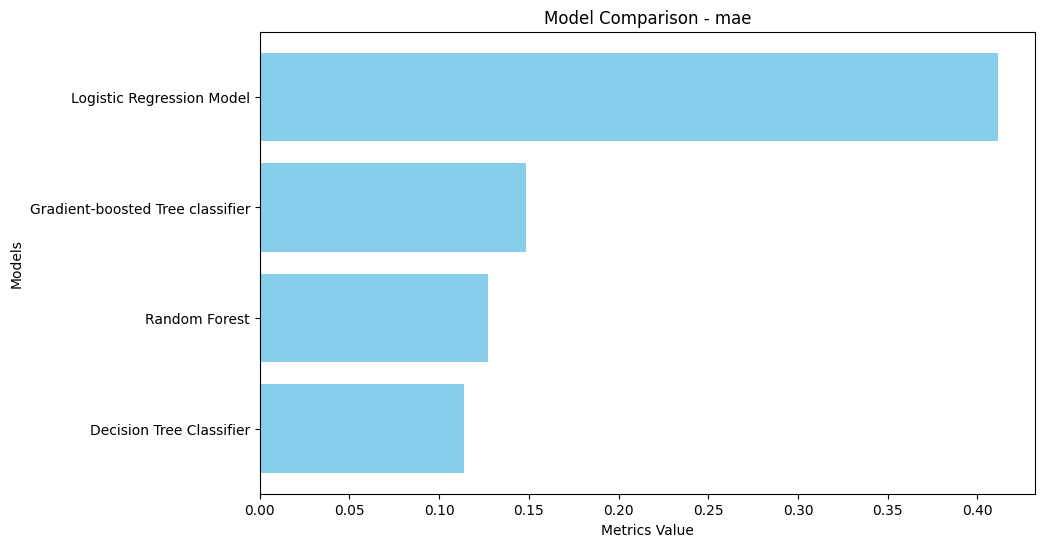

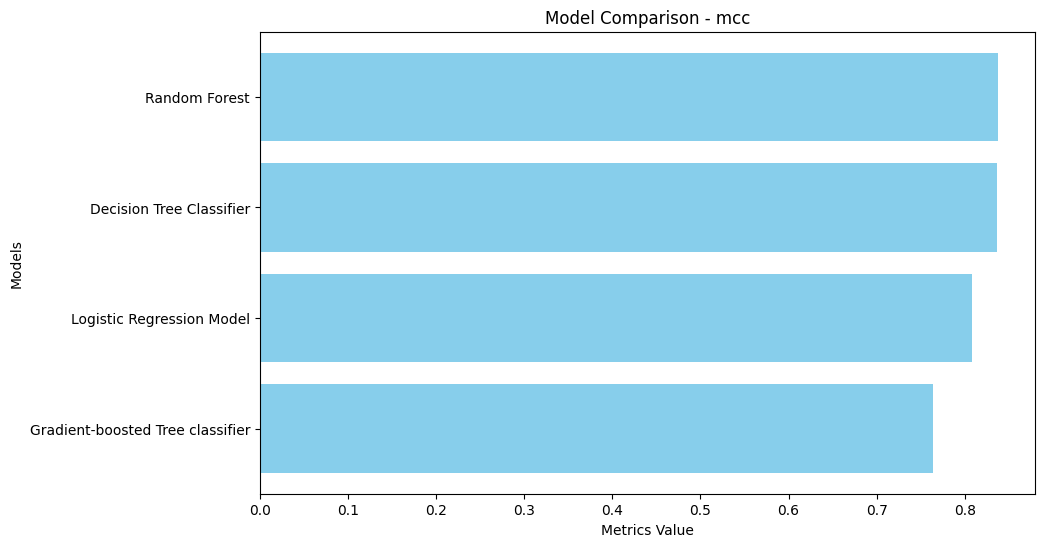

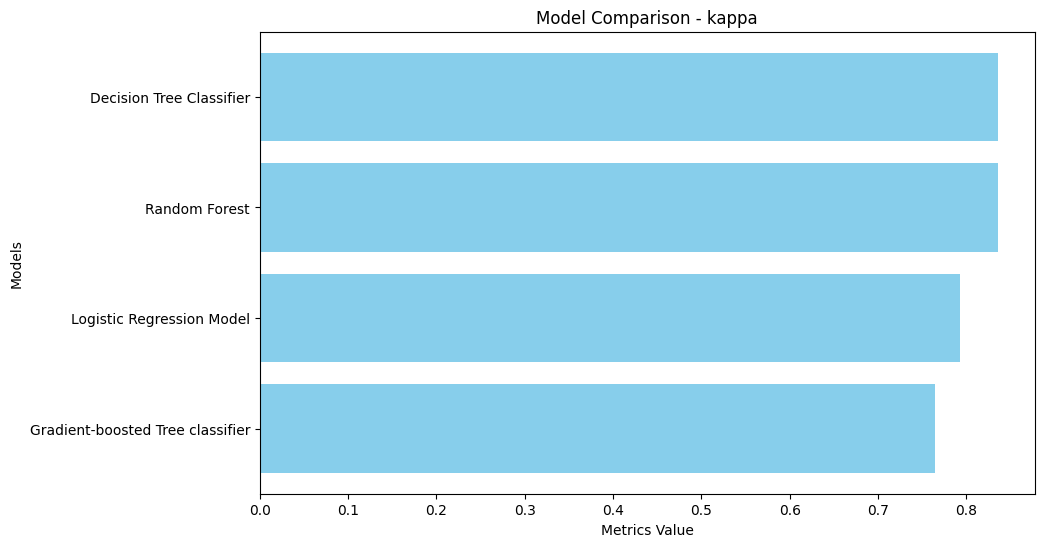

In [220]:
# Plot model comparison
plot_model_comparison(models_metrics)

# Boxplot comparisons

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

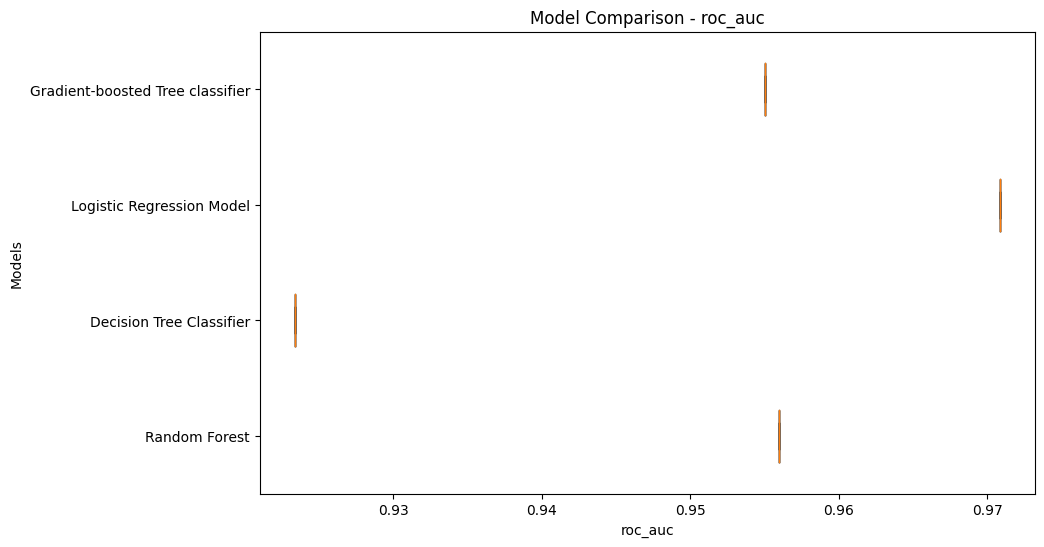

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

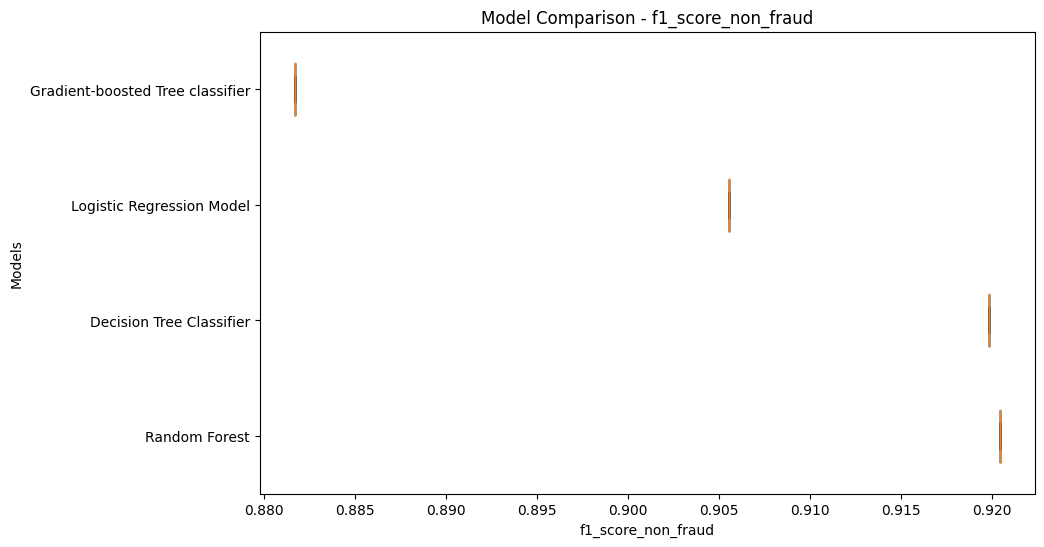

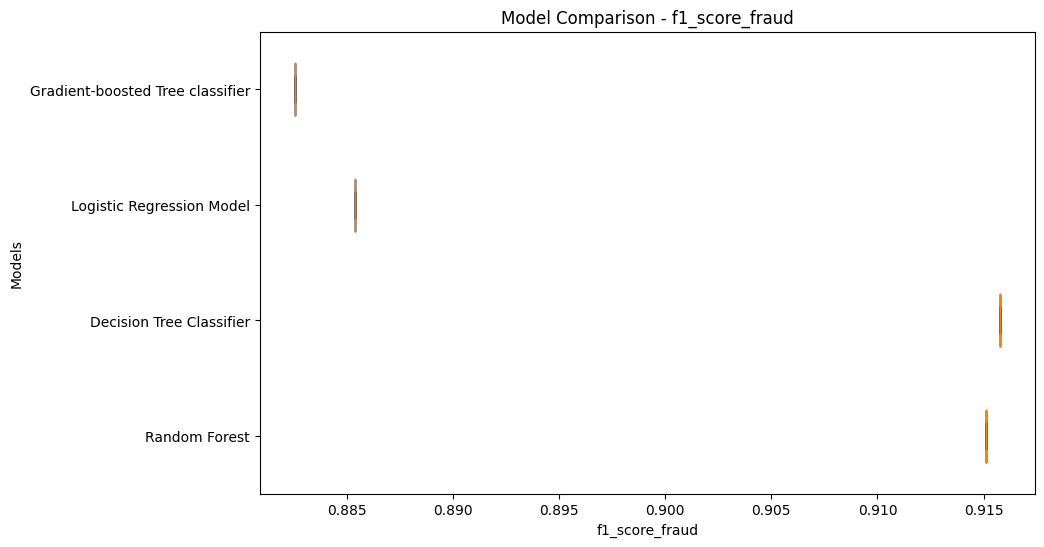

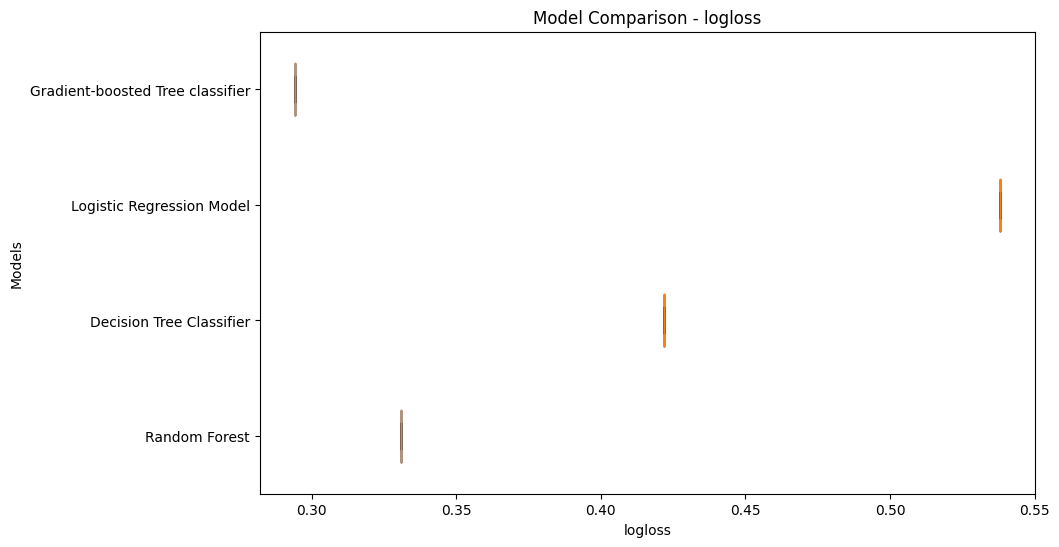

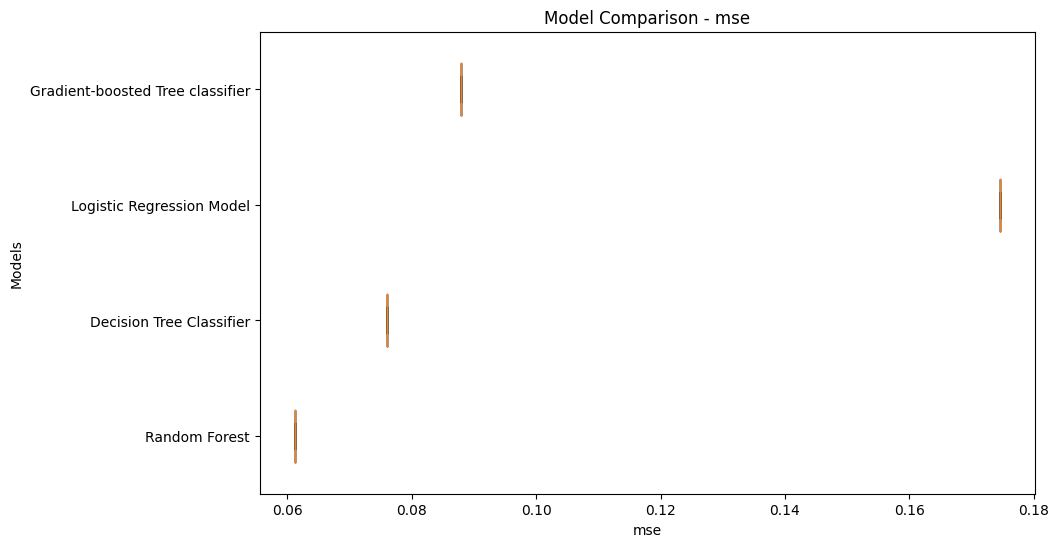

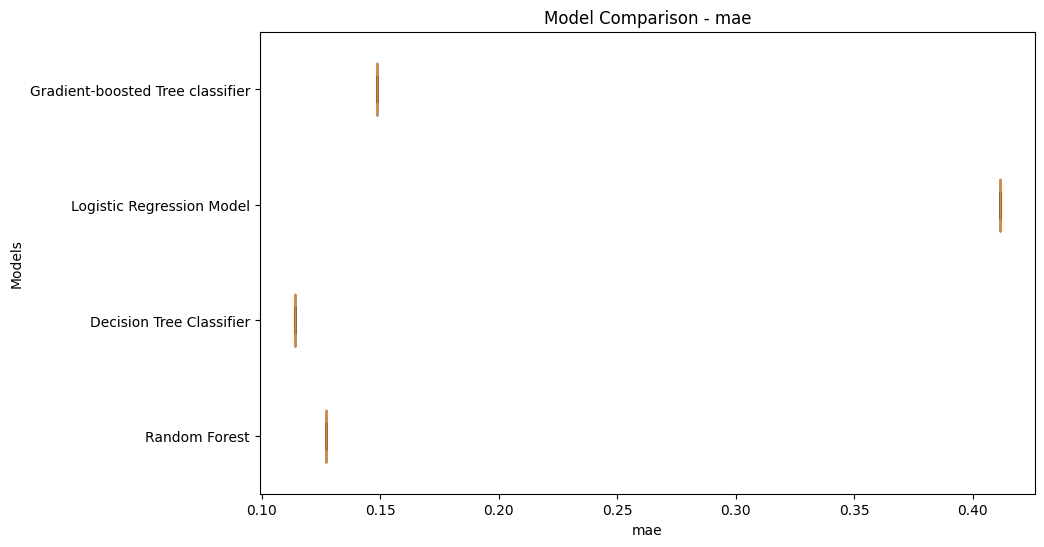

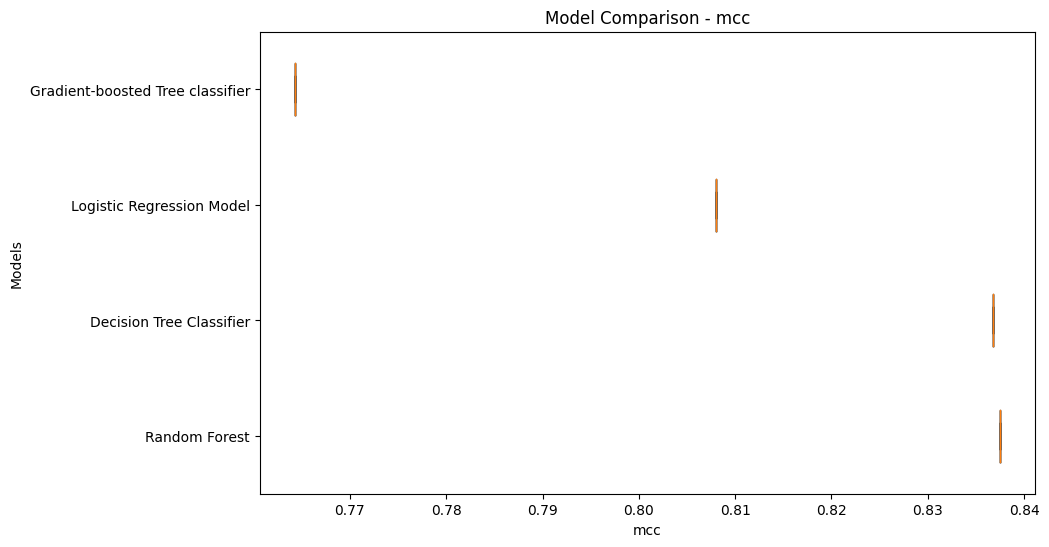

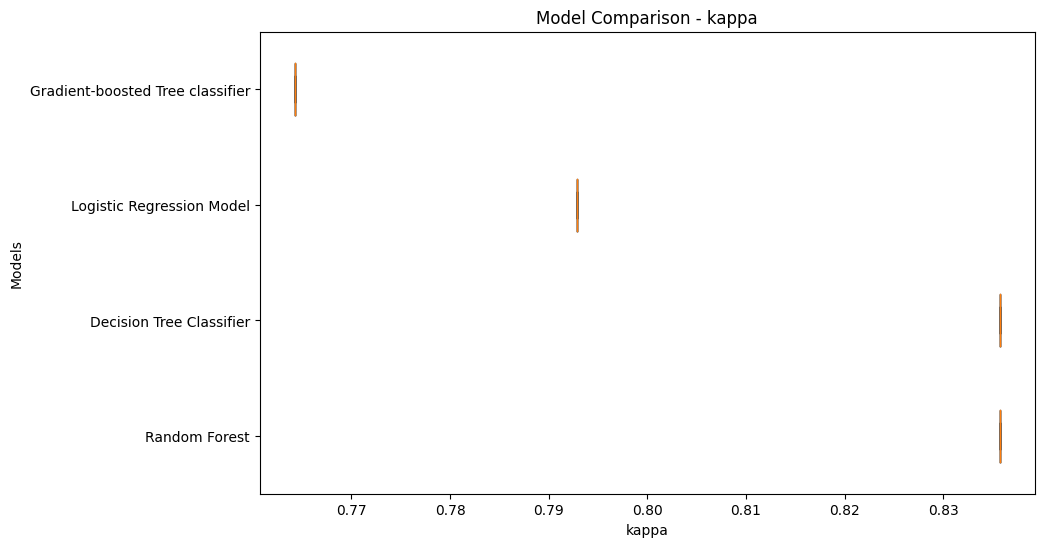

In [259]:
def plot_model_boxplot_comparison(models_metrics):
    models = list(models_metrics.keys())
    metrics = list(models_metrics[models[0]].keys())  # Get the list of metrics from the first model

    for metric in metrics:
        plt.figure(figsize=(10, 6))  # Create a new figure for each metric
        model_data = []

        # Collect the data for each model
        for model in models:
            metric_values = models_metrics[model][metric]
            # Filter out non-numeric values and empty lists
            if isinstance(metric_values, (int, float)):
                model_data.append([metric_values])
            elif isinstance(metric_values, list):
                valid_values = [value for value in metric_values if isinstance(value, (int, float))]
                if valid_values:
                    model_data.append(valid_values)

        # Sort the model data
        sorted_model_data = [sorted(data) for data in model_data]

        # Check if there's any data to plot
        if sorted_model_data:
            # Transpose the data to plot horizontally
            plt.boxplot(sorted_model_data, labels=models, vert=False)

            plt.xlabel(metric)
            plt.ylabel('Models')
            plt.title(f'Model Comparison - {metric}')
            plt.show()

# Example usage:
plot_model_boxplot_comparison(models_metrics)



